# Diffusion Models

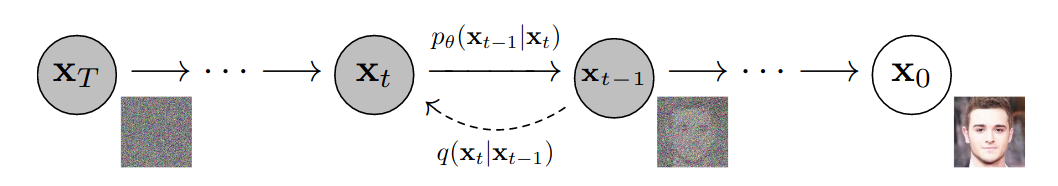

In this image, the distribution $q_{theta}$ represents the forward diffusion process. Below, I simulate the forward diffusion process on a simple distribution. Later, we'll reverse the diffusion process to obtain a generative model of data. 

Trajectory length:  41


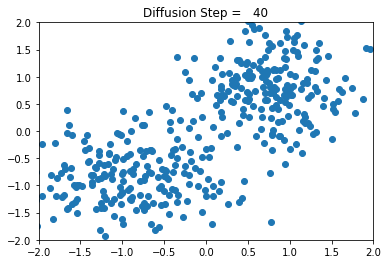

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import *
from torch import optim
import math
from sympy import * 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
import random
from tqdm import tqdm
    
%matplotlib inline

init_printing()

data1 = np.array([1., 1.]) + 0.01 * np.random.randn(200, 2)
data2 = np.array([-1., -1.]) + 0.01 * np.random.randn(200, 2)
data = np.concatenate((data1, data2))
pts = data

STEPS = 40 # Diffusion steps
BETA = 1e-2 # Diffusion rate

def forward_step (pts, t) : 
    mu_new = pts * np.sqrt(1 - BETA)
    pts_ = mu_new + np.sqrt(BETA) * np.random.randn(*mu_new.shape)
    return pts_

fig, ax = plt.subplots()

ax.set_xlim((-2, 2))            
ax.set_ylim((-2, 2))
txt_title = ax.set_title('')
scat = ax.scatter([], [])

xs = []
for i in range(STEPS) :
    xs.append(pts)
    pts = forward_step(pts, i + 1)
xs.append(pts)
print("Trajectory length: ", len(xs)) 

def drawframe (t):
    scat.set_offsets(xs[t])
    txt_title.set_text('Diffusion Step = {0:4d}'.format(t))
    return (scat,)

anim = animation.FuncAnimation(fig, drawframe, frames=STEPS + 1, interval=200, blit=True)
HTML(anim.to_html5_video())

## Fixed Point of Forward Diffusion

The forward diffusion process consists of perturbing points by sampling their new location from a gaussian distribution. Here, $\beta_t$ is the diffusion rate, determining how far points can go in the $t^{th}$ time-step. 

$$
X^{(t)} | X^{(t - 1)} \sim \mathcal{N} (\sqrt{1 - \beta_t} X^{(t - 1)}, \beta_t I)
$$

The animation shows that after certain time-steps, the points are distributed as per isotropic gaussian. Why does this happen? Why is the isotropic gaussian the fixed point of the forward diffusion kernel. 

A simple way to see what is happening is to look at one point in the data-set and see what it's probability distribution looks like after two steps of diffusion.

$$ x_0 \rightarrow x_1 \rightarrow x_2 $$

Then $Pr(X^{(2)} = x_2 | X^{(0)} = x_0)$ is given by:

In [2]:
def gaussian (x, mu, sigma) : 
    """ 
    Expression for probability at x according to 
    gaussian distribution.
    """
    return 1 / (sigma * sqrt(2 * pi)) * exp(-((x - mu) / sigma) ** 2 / 2)

var('x_0 x_1 x_2 pi beta_1 beta_2 Z')

I = gaussian(x_1, x_0 * sqrt(1 - beta_1), sqrt(beta_1)) * gaussian(x_2, x_1 * sqrt(1 - beta_2), sqrt(beta_2))
I = simplify(I)
pprint(Integral(I, (x_1, -oo, oo)))

∞                                                        
⌠                                                        
⎮                         2                       2      
⎮     ⎛     ________     ⎞    ⎛     ________     ⎞       
⎮     ⎝x₁⋅╲╱ 1 - β₂  - x₂⎠    ⎝x₀⋅╲╱ 1 - β₁  - x₁⎠       
⎮   - ───────────────────── - ─────────────────────      
⎮              2⋅β₂                    2⋅β₁              
⎮  ℯ                                                     
⎮  ──────────────────────────────────────────────── d(x₁)
⎮                     ____   ____                        
⎮                 2⋅╲╱ β₁ ⋅╲╱ β₂ ⋅π                      
⌡                                                        
-∞                                                       


We'll solve this integral with these steps.

* Complete the square in the exponent in terms of $x_1$
* Notice that the integrand is a gaussian in $x_1$
* Divide and multiply it by normalization constant
* Everything left after integrating over $x_1$ is the distribution of the second diffusion step

In [3]:
# Perform step 1
def completeSquare (quadratic, x) : 
    """ 
    Write the quadratic as (A * x - B) ** 2 - C
    and obtain expressions for coefficients A, B and C
    """ 
    A = sqrt(simplify(diff(quadratic, x, x) / 2))
    exp = simplify(diff(quadratic, x).subs(x, 0))
    B = simplify(exp / (-2 * A)) 
    C = simplify(B ** 2 - quadratic.subs(x, 0))
    return { 'A': A, 'B': B, 'C': C }

C_1 = Wild("C_1")
C_2 = Wild("C_2")
E = Wild("E")

print("Integral is of the form:\n")
pprint(Integral(C_1 * exp(-C_2 * E), (x_1, -oo, oo)))

print("Where E is:\n")
match = I.match(C_1 * exp(-C_2 * E))
E = match[E].expand()
pprint(E)

print("After completing the square\n")

perfectSq = completeSquare(E, x_1)
A, B, C = Wild("A"), Wild("B"), Wild("C")
pprint(Integral(C_1 * exp(-C_2 * ((A * x_1 ** 2 - B) ** 2 - C)), (x_1, -oo, oo)))

Integral is of the form:

∞                 
⌠                 
⎮      -C₂⋅E      
⎮  C₁⋅ℯ      d(x₁)
⌡                 
-∞                
Where E is:

    2     2     2            ________     2      2            ________     2 
  x₀    x₁    x₁     x₁⋅x₂⋅╲╱ 1 - β₂    x₂     x₀     x₀⋅x₁⋅╲╱ 1 - β₁    x₁  
- ─── - ─── + ──── - ──────────────── + ──── + ──── - ──────────────── + ────
   2     2    2⋅β₂          β₂          2⋅β₂   2⋅β₁          β₁          2⋅β₁
After completing the square

∞                                   
⌠                                   
⎮          ⎛                2⎞      
⎮          ⎜     ⎛  2      ⎞ ⎟      
⎮      -C₂⋅⎝-C + ⎝x₁ ⋅A - B⎠ ⎠      
⎮  C₁⋅ℯ                        d(x₁)
⌡                                   
-∞                                  


In [4]:
# Perform step 4: bring out everything independent of x_1
print("Terms independent of x_1 are seperated:\n") 
pprint(C_1 * exp(C_2 * C) * Integral(exp (-C_2 * (A ** 2) * (x_1 - B / A) ** 2), (x_1, -oo, oo)))

print("The integral evaluates to some constant Z:\n")
pprint(C_1 * exp(C_2 * C) * Z)

print("To find the resulting gaussian parameters, just need to look at C_2 * C:\n")
C = perfectSq['C']
psq = completeSquare(C, x_2)
C = simplify((psq['A'] * x_2 - psq['B']) ** 2 - psq['C'])
pprint(match[C_2] * C)

Terms independent of x_1 are seperated:

         ∞                         
         ⌠                         
         ⎮                  2      
         ⎮     2    ⎛     B⎞       
         ⎮   -A ⋅C₂⋅⎜x₁ - ─⎟       
    C⋅C₂ ⎮          ⎝     A⎠       
C₁⋅ℯ    ⋅⎮  ℯ                 d(x₁)
         ⌡                         
         -∞                        
The integral evaluates to some constant Z:

      C⋅C₂
Z⋅C₁⋅ℯ    
To find the resulting gaussian parameters, just need to look at C_2 * C:

                                 2
⎛       ________   ________     ⎞ 
⎝- x₀⋅╲╱ 1 - β₁ ⋅╲╱ 1 - β₂  + x₂⎠ 
──────────────────────────────────
       2⋅(β₁⋅β₂ - β₁ - β₂)        


Matching this expression with:

$$-\frac{(x_2 - \mu)^2}{2 \sigma^2}$$

We get: 

$$ 
\mu = \sqrt{1 - \beta_1} \sqrt{1 - \beta_2} x_0
$$

$$
\sigma^2 = 1 - (1 - \beta_1) (1 - \beta_2)
$$

Applying this result iteratively, we get: 

$$
Pr(X^{(t)} = x_t | X^{(0)} = x_0) = \mathcal{N}(\prod_{i = 1}^t \sqrt{1 - \beta_i} x_0, 1 - \prod_{i = 1}^t (1 - \beta_i))
$$

Taking $t$ to the limit, it is easy to see that the distribution becomes an isotropic gaussian.

## Generating Data by Reversing Diffusion

The generative model is defined by the reverse diffusion process. Each step in the reverse diffusion process is also from a gaussian distribution. The mean and covariance of this distribution are learnt from the data-set. The probability assigned by the model to a data-point is given below. RP stands for the reverse diffusion process and FP stands for the forward diffusion process.

$$
Pr_{MODEL}(X^{(0)} = x_{0}) = \int Pr_{RP}(X^{(0)} = x_{0} \cdots X^{(T)} = x_T) dx_{1 \cdots T}
$$

We'll massage this equation into a form from which deriving a lower bound to the log likelihood - our training objective - is convenient. I can't motivate this step. This is something that Jarzynski found out about.

$$
= \int Pr_{RP}(X^{(0)} = x_{0} \cdots X^{(T)} = x_T) \frac{Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0})}{Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0})} dx_{1 \cdots T}
$$

$$
= \int Pr_{RP}(X^{(T)} = x_T) Pr_{FP}(X^{(1)} = x_{1} \cdots X^{(T)} = x_T | X^{(0)} = x_{0}) \prod_{t = 1}^T \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t)} = x_{t} | X^{(t - 1)} = x_{t - 1})} dx_{1 \cdots T}
$$

$$
= \mathbb{E}_{Pr_{FP}(X^{(1)} \cdots X^{(T)}| X^{(0)})} \Big[Pr_{RP}(X^{(T)}) \prod_{t = 1}^T \frac{Pr_{RP}(X^{(t - 1)} | X^{(t)})}{Pr_{FP}(X^{(t)} | X^{(t - 1)})} \Big]
$$

I'll abbreviate this equation as: 

$$
= \mathbb{E} \Big[Pr_{RP}(X^{(T)}) \prod_{t = 1}^T R_t \Big]
$$

## Training Objective

The training objective is a lower bound on the log likelihood. The steps involved in arriving at the objective are:

* Derive Lower Bound using Jensen's Inequality
* Get rid of all terms that don't involve model parameters i.e. constants

$$
L = \int Pr_{DATA} (X^{(0)} = x_0) log \Big( \mathbb{E} \Big[Pr_{RP}(X^{(T)}) \prod_{t = 1}^T R_t \Big] \Big) dx_0
$$

$$
\geq \int Pr_{DATA} (X^{(0)} = x_0) \mathbb{E} \Big[log \Big(Pr_{RP}(X^{(T)}) \prod_{t = 1}^T R_t \Big) \Big] dx_0 = K 
$$

$$ 
K = \int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big( \color{red}{Pr_{RP}(X^{(T)} = x_T)} \prod_{t = 1}^T R_t \Big) dx_{0 \cdots T} 
$$

Recall that the expectation was computed over the forward diffusion process conditioned on $X^{(0)}$. This is the lower bound that we are finally going to optimize. This expression has a lot of constant terms. So we'll step-by-step get rid of them. First seperate out $\color{red}{Pr_{RP}(X^{(T)})}$. 

$$
\color{red}{\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log Pr_{RP}(X^{(T)}) dx_{0 \cdots T}}
$$

Now we are going to normalize all the random variables that we don't care about. To do this, apply Bayes Rule and integrate.

$$
Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) = Pr_{FP}(X^{(0)} = x_0 \cdots X^{(T - 1)} = x_{T - 1}) Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)} = x_{T - 1})
$$

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) dx_{0 \cdots T - 2} = Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)} = x_{T - 1}) \int Pr_{FP}(X^{(0)} = x_0 \cdots X^{(T - 1)} =  x_{T - 1})  dx_{0 \cdots T - 2}
$$

$$ 
= Pr_{FP}(X^{(T)} = x_T | X^{(T - 1)}) Pr_{FP}(X^{(T - 1)} = x_{T - 1})
$$

$$
= Pr_{FP}(X^{(T)} = x_T)
$$

Now the red term becomes: 

$$
\color{red}{\int Pr_{FP}(X^{(T)} = x_T) log \Big(Pr_{RP}(X^{(T)} = x_T) \Big) dx_T}
$$

Since after $T$ timesteps, we assume that the diffusion is complete, $Pr_{FP}(X^{(T)} = x_T) = Pr_{RP}(X^{(T)} = x_T) = \mathcal{N}(0, I)$. Hence this integral is the entropy of the standard normal distribution which is some constant that doesn't effect our optimization. The rest of the stuff is: 

$$ 
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \prod_{t = 1}^T R_t dx_{0 \cdots T} 
$$

$$
= \sum_{t = 1}^T \Bigg( \int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log R_t dx_{0 \cdots T} \Bigg)
$$

Let's examine a particular term in this sum:

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t)} = x_t | X^{(t - 1)} = x_{t - 1})} dx_{0 \cdots T}
$$

We don't like that the conditionals in the log ratio are on different random variable. We'll fix this in 2 steps:

1. Use the markov property: 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t)} = x_t | X^{(t - 1)} = x_{t - 1}, X^{(0)} = x_{0})} dx_{0 \cdots T}
$$

2. Use the bayes rule: 

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \Big( \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} \color{green}{\frac{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(0)} = x_0)}{Pr_{FP}(X^{(t)} = x_t | X^{(0)} = x_0)}} \Big) dx_{0 \cdots T}
$$

The green terms are independent of the model parameters and can be dropped. The remaining stuff is:  

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(T)} = x_T) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} dx_{0 \cdots T}
$$

Again normalizing all random variables beyond $i$:

$$
\int Pr_{FP} (X^{(0)} = x_0 \cdots X^{(t)} = x_t) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} dx_{0 \cdots t}
$$

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP} (X^{(1)} = x_1 \cdots X^{(t)} = x_t | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} dx_{0 \cdots t}
$$

Obviously, this step is valid only when $t \geq 2$. It turns out we don't have to worry about $t = 1$. I don't know why but you can imagine that in a long reverse diffusion process, the final step doesn't matter so much. 

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP}(X^{(t - 1)} = x_{t - 1}, X^{(t)} = x_{t} | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} dx_{0}x_{t - 1}x_{t}
$$

Using Bayes Rule: 

$$
= \int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP}(X^{(t - 1)} = x_{t - 1} |X^{(t)} = x_{t}, X^{(0)} = x_0) Pr_{FP} (X^{(t)} = x_{t} | X^{(0)} = x_0) log \frac{Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)}{Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0})} dx_{0}x_{t - 1}x_{t}
$$

Noticing that the integral over $x_{t - 1}$ is KL Divergence

$$
= -\int Pr_{DATA}(X^{(0)} = x_0) Pr_{FP} (X^{(t)} = x_{t} | X^{(0)} = x_0) D_{KL}\Big(Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0}) \Big|\Big| Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)\Big) dx_{0}x_{t}
$$

$$
= -\int Pr_{FP}(X^{(0)} = x_0, X^{(t)} = x_{t}) D_{KL}\Big(Pr_{FP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_{t}, X^{(0)} = x_{0}) \Big|\Big| Pr_{RP}(X^{(t - 1)} = x_{t - 1} | X^{(t)} = x_t)\Big) dx_{0}x_{t}
$$

$$
= -\mathbb{E} \Bigg[D_{KL}\Big(Pr_{FP}(X^{(t - 1)} | X^{(t)}, X^{(0)}) \Big|\Big| Pr_{RP}(X^{(t - 1)} | X^{(t)})\Big) \Bigg]
$$

$$
= -\mathbb{E} \Bigg[D_{KL}\Big(Pr_{FP}(X^{(t)} | X^{(t - 1)}) \frac{Pr_{FP}(X^{(t - 1)} | X^{(0)})}{Pr_{FP}(X^{(t)} | X^{(0)})} \Big|\Big| Pr_{RP}(X^{(t - 1)} | X^{(t)})\Big) \Bigg]
$$

Where the expectation is over $x_0, x_t$ generated during the diffusion process. This expectation can be estimated from a minibatch of the forward diffusion trajectory.

## Helpful Identities 

### KL Divergence between two gaussian distributions

$$
D_{KL}(\mathcal{N}(\mu_0, \Sigma_0) || \mathcal{N}(\mu_1, \Sigma_1)) 
$$

$$
= \frac{1}{2} \Big( tr(\Sigma_1^{-1}\Sigma_0) + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - k + ln\frac{|\Sigma_1|}{|\Sigma_0|}\Big)
$$

$k$ is the dimension of the random variable.

Pytorch:

In [5]:
def kl_divergence (mu_0, cov_0, mu_1, cov_1) : 
    _, k = mu_0.shape
    t1 = (torch.log(cov_1) - torch.log(cov_0)).sum(1)
    t2 = (((mu_1 - mu_0) / (cov_1 + 1e-6)) * (mu_1 - mu_0)).sum(1)
    t3 = (cov_0 / (cov_1 + 1e-6)).sum(1)
    return 0.5 * (t1 + t2 + t3 - k).mean()

mu = torch.tensor([[0.4, 0.2, 0.1]])
cov = torch.tensor([[1., 2., 10.]])
print('KL Divergence: ', kl_divergence(mu, cov, mu, cov)) # ~ 0

KL Divergence:  tensor(-7.1526e-07)


### Product of two gaussian distributions

In [6]:
var('x_p sigma_1 sigma_2 mu_1 mu_2')
P = simplify(gaussian(x_p, mu_1, sigma_1) * gaussian(x_p, mu_2, sigma_2))
print("The first distribution in KL is proportional to:\n") 
pprint(P)

C_1, E = Wild("C_1"), Wild("E")
E = P.match(C_1 * exp(-E/2))[E]
print("Check the exponent to get mean and sigma:\n")
pprint(E)

E = E.expand()

csq = completeSquare(E, x_p)

print("After completing the square, we really see what mean and sigma look like:\n")
print("P is proportional to:\n") 
pprint(exp(-(csq['A'] * x_p - csq['B']) ** 2 / 2))

print("Mean of product of gaussians is:\n") 
pprint((mu_1 * sigma_2 ** 2 + mu_2 * sigma_1 ** 2) / (sigma_1 ** 2 + sigma_2 ** 2))

print("Standard deviation is:\n") 
pprint(1 / sqrt(1 / sigma_1 ** 2 + 1 / sigma_2 ** 2))

The first distribution in KL is proportional to:

            2            2
   (μ₂ - xₚ)    (μ₁ - xₚ) 
 - ────────── - ──────────
         2            2   
     2⋅σ₂         2⋅σ₁    
ℯ                         
──────────────────────────
        2⋅π⋅σ₁⋅σ₂         
Check the exponent to get mean and sigma:

         2            2
(μ₂ - xₚ)    (μ₁ - xₚ) 
────────── + ──────────
     2            2    
   σ₂           σ₁     
After completing the square, we really see what mean and sigma look like:

P is proportional to:

                                                  2 
  ⎛        ___________            2        2     ⎞  
  ⎜       ╱  1     1         μ₁⋅σ₂  + μ₂⋅σ₁      ⎟  
 -⎜xₚ⋅   ╱  ─── + ───  - ────────────────────────⎟  
  ⎜     ╱     2     2                 ___________⎟  
  ⎜   ╲╱    σ₂    σ₁       2   2     ╱  1     1  ⎟  
  ⎜                      σ₁ ⋅σ₂ ⋅   ╱  ─── + ─── ⎟  
  ⎜                                ╱     2     2 ⎟  
  ⎝                              ╲╱    σ₂    σ₁  

Pytorch: 

In [7]:
def product_of_gaussians (mu_0, cov_0, mu_1, cov_1) : 
    mu = ((mu_0 * cov_1) + (mu_1 * cov_0)) / (cov_0 + cov_1 + 1e-6)
    cov = (cov_0 * cov_1) / (cov_0 + cov_1 + 1e-6)
    return mu, cov

mu = torch.tensor([[1.]])
cov = torch.tensor([[1.]])
print("Product of gaussians: ", *product_of_gaussians(mu, cov, mu, cov)) # mu = 1, cov = 0.5

mu_1, mu_2 = torch.tensor([[-10.]]), torch.tensor([[10.]])
print("Product of gaussians: ", *product_of_gaussians(mu_1, cov, mu_2, cov)) # mu = 0

Product of gaussians:  tensor([[1.0000]]) tensor([[0.5000]])
Product of gaussians:  tensor([[0.]]) tensor([[0.5000]])


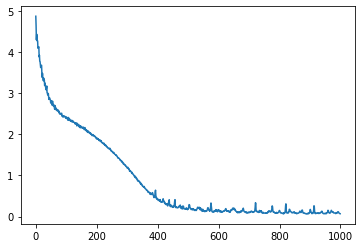

In [8]:
class BoundedParameter (nn.Module) :
    
    def __init__ (self, init=0.) :
        super(BoundedParameter, self).__init__()
        self.x = nn.Parameter(torch.tensor(init))
    
    def forward (self) : 
        return torch.sigmoid(self.x)
    
class DiffusionModel (nn.Module) : 
    
    def __init__ (self, inDim=2, hiddenDim=64) : 
        super(DiffusionModel, self).__init__()
        self.inDim = inDim 
        self.hiddenDim = hiddenDim 
        self.shared = nn.Sequential(
            nn.Linear(inDim, hiddenDim),
            nn.ReLU()
        )
        # Predict the mean for the reverse process
        self.f_means = nn.ModuleDict([
            [str(t), nn.Linear(hiddenDim, inDim)]
            for t in range(STEPS, 1, -1)
        ])
        # Predict diagonal covariance matrices of the reverse process
        self.f_covs = nn.ModuleDict([
            [str(t), nn.Sequential(nn.Linear(hiddenDim, inDim), nn.Sigmoid())]
            for t in range(STEPS, 1, -1)
        ])
        self.beta_1 = 1e-2
        self.beta_t = nn.ModuleDict([
            [str(t), BoundedParameter(-4.)]
            for t in range(STEPS, 1, -1)
        ])
        
    def drift (self, t) : 
        prod = math.sqrt(1 - self.beta_1)
        for i in range(2, t + 1) : 
            prod = prod * torch.sqrt(1 - self.beta_t[str(i)]())
        return prod
            
    def span (self, t) : 
        prod = (1 - self.beta_1)
        for i in range(2, t + 1) : 
            prod = prod * (1 - self.beta_t[str(i)]())
        return 1 - prod   
        
    def mean (self, x, t) : 
        f = self.shared(x)
        return self.f_means[str(t)](f)
    
    def cov (self, x, t) :
        f = self.shared(x)
        return self.f_covs[str(t)](f)
    
    def sample_forward_trajectory (self, x0, bs) : 
        N, _ = x0.shape
        ids = random.sample(list(range(N)), bs)
        x = data[ids, :] 
        pts = [x]
        for i in range(1, STEPS + 1) : 
            if i == 1 : 
                beta = self.beta_1
            else :
                beta = self.beta_t[str(i)]().detach().numpy()
            mu_new = pts[-1] * np.sqrt(1 - beta)
            x_ = mu_new + np.sqrt(beta) * np.random.randn(*mu_new.shape)
            pts.append(x_)
        pts = np.stack(pts)
        return pts
    
    def sample_backward_trajectory (self, nSamples) :
        """ 
        Return the whole trajectory starting from the 
        isotropic gaussian
        """ 
        xs = []
        Pi = MultivariateNormal(torch.zeros(model.inDim), torch.eye(model.inDim))
        xs.append(Pi.sample((nSamples,)))
        for t in range(STEPS, 1, -1) : 
            mu, c = self.mean(xs[-1], t), self.cov(xs[-1], t)
            P = MultivariateNormal(torch.flatten(mu), torch.diag(torch.flatten(c)))
            xs.append(P.sample((1,)).reshape(-1, model.inDim))
        return xs
        
    def objective (self, x0, xt, t) :
        """
        x0, xt have shape [batch_size, inDims]
        """
        if t == 2 : 
            beta = self.beta_1
        else :
            beta = self.beta_t[str(t - 1)]()
            
        alpha = 1 - beta
        mu_0, cov_0 = product_of_gaussians(
            xt / math.sqrt(alpha),
            (beta / alpha) * torch.ones_like(x0),
            self.drift(t - 1) * x0,
            self.span(t - 1) * torch.ones_like(x0)
        )  
        mu_1 = self.mean(xt, t) 
        cov_1 = self.cov(xt, t)

        return kl_divergence(mu_0, cov_0, mu_1, cov_1)
        
    def forward (self, x) : 
        """
        xs shape is [STEPS + 1, batch_size, inDims]
        """
        _, bs, _ = x.shape
        x0 = x[0, :, :] 
        loss = 0 
        for t in range(STEPS, 1, -1) : 
            xt = x[t, :, :]
            loss_t = self.objective(x0, xt, t)
            loss += loss_t
        loss /= STEPS
        return loss

N_EPOCH = 1000 # Number of epochs

model = DiffusionModel()
model.float()
opt = optim.SGD(model.parameters(), lr=6e-2)
losses = []
for i in range(N_EPOCH) : 
    x = model.sample_forward_trajectory(data, 100)
    x = torch.from_numpy(x).float()
    loss = model.forward(x)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    
plt.plot(range(N_EPOCH), losses)

tensor([0.1404, 0.0235])
tensor([0.9666, 0.9294])


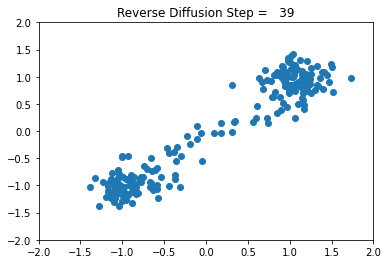

In [9]:
xs = model.sample_backward_trajectory(200)
fig, ax = plt.subplots()

ax.set_xlim((-2, 2))            
ax.set_ylim((-2, 2))
txt_title = ax.set_title('')
scat = ax.scatter([], [])

def drawframe (t):
    global pts
    scat.set_offsets(xs[t % len(xs)])
    txt_title.set_text('Reverse Diffusion Step = {0:4d}'.format(t))
    return (scat,)

anim = animation.FuncAnimation(fig, drawframe, frames=STEPS, interval=200, blit=True)
print(xs[-1].mean(0))
print(xs[-1].std(0))
HTML(anim.to_html5_video())

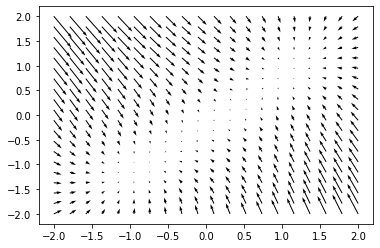

In [10]:
x,y = np.meshgrid(np.linspace(-2,2,20),np.linspace(-2,2,20))
x,y = x.reshape(-1, 1), y.reshape(-1, 1)
X = np.hstack([x, y])
F = model.mean(torch.from_numpy(X).float(), 2).detach().numpy() - X
plt.quiver(X[:, 0], X[:, 1], F[:, 0], F[:, 1])
plt.show()

## References 

1. Deep Unsupervised Learning using Nonequilibrium Thermodynamics
2. Denoising Diffusion Probabilistic Models